# Classificação de Sons Urbanos com Deep Learning
#### Projeto de Aprendizagem Computacional II


### Indice
#### 1. Visão Geral
#### 2. Bibliotecas Necessárias
#### 3. Análise de Dados
#### 4. Modelagem e Avaliação


### Visão Geral
#### Este projeto aborda a tarefa de classificar sons urbanos utilizando machine learning. O conjunto de dados usado é o UrbanSound8k, que contém 8 732 amostras de áudio rotuladas em dez categorias. O objetivo é construir modelos de deep learning para identificar com precisão a classe correspondente a cada som.

### Bibliotecas Utilizadas:

In [57]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix

### Preparando os Dados
#### Os dados de entrada para as redes neurais foram extraídos e processados utilizando a biblioteca Librosa, que permite pré-processar os arquivos de áudio e obter características relevantes. Como os arquivos apresentavam diferentes durações e taxas de amostragem, padronizamos os inputs da rede. Abaixo está um script Python usado para essa tarefa. 

### Executar o comando a seguir para gerar os conjuntos de dados com as características extraídas:
% python features.py

### Carregar o Conjunto de Dados
#### Alterar os nomes dos arquivos de dataset caso necessário.

In [58]:
datasets = [pd.read_csv(f'datasets/urbansounds_featuresfold{i}.csv') for i in range(1, 11)]

### Verificar e Preparar os Dados

#### Identificar colunas que contêm dados do tipo `object`

In [59]:
# Loop para verificar cada DataFrame no conjunto de dados
for df in datasets:
    colunas_objeto = df.select_dtypes(include=['object']).columns
    print(f"Colunas com tipo objeto: {colunas_objeto}")

Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')
Colunas com tipo objeto: Index(['fourier_tempogram', 'Label'], dtype='object')


#### Função para calcular a média de números extraídos de uma string

In [60]:
def media_de_valores(string):
    # Remover quebras de linha
    string_limpa = string.replace('\n', '')
    
    # Extrair todos os números presentes na string
    valores = re.findall(r"[-+]?\d*\.\d+|\d+", string_limpa)
    
    # Converter para um array NumPy de tipo float
    array = np.array(valores, dtype=float)
    
    # Calcular e retornar a média
    media = np.mean(array)
    return media

#### Função para verificar os valores extremos (mínimos e máximos) de cada coluna


In [61]:
def verificar_valores_extremos():
    for i, df in enumerate(datasets[:10]):
        # Selecionar apenas colunas numéricas
        colunas_numericas = df.select_dtypes(include=['int', 'float'])
        
        print(f"Conjunto de Dados {i + 1}:")
        for column in colunas_numericas.columns:
            valor_min = colunas_numericas[column].min()
            valor_max = colunas_numericas[column].max()
            print(f"  Coluna: {column}, Mínimo: {valor_min}, Máximo: {valor_max}")
        
        print("\n" + "="*30 + "\n")


#### Converter colunas de texto em valores numéricos, normalizar e ajustar a coluna de rótulos

In [62]:
for df in datasets:
    for column in df.columns:
        # Processar apenas colunas diferentes de 'Label'
        if column != 'Label':
            # Converter strings para valores numéricos, se necessário
            if df[column].dtype not in [float, int]:
                df[column] = df[column].apply(media_de_valores)
            # Normalizar os valores para o intervalo [0, 1]
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        else:
            # Ajustar os rótulos para corresponder à classe numérica
            df[column] = df[column].str.split('-').str[1].astype(int)


### Visualização das Classes
#### Função para criar gráficos que mostram a distribuição das classes

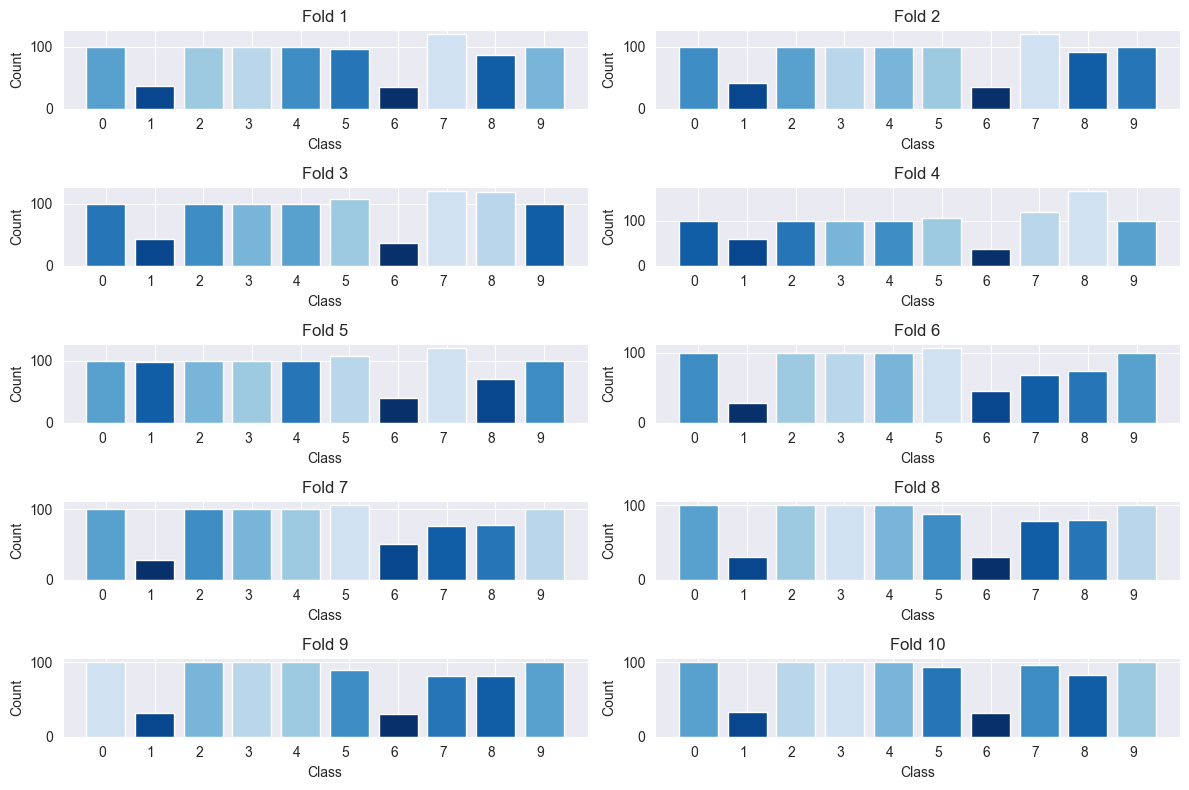

In [63]:
def visualizar_distribuicao_classes(dataset):
    fold = 0
    rows = int(np.ceil(len(dataset) / 2))
    columns = 2
    fig, eixos = plt.subplots(rows, columns, figsize=(12, 8))
    mapa_cores = plt.get_cmap('Blues')

    # Iterar sobre cada conjunto de dados e eixo
    for df, eixo in zip(dataset, eixos.flat):
        # Contar o número de ocorrências por classe
        contagem_classes = df['Label'].value_counts()
        rotulos_classes = contagem_classes.index
        valores_classes = contagem_classes.values

        # Configurar cores para o gráfico
        cores = mapa_cores(np.linspace(0.2, 1, len(rotulos_classes)))
        
        # Criar o gráfico de barras
        eixo.bar(rotulos_classes, valores_classes, color=cores)
        eixo.set(xlabel='Class', ylabel='Count', title=f'Fold {fold + 1}')
        eixo.set_xticks(rotulos_classes)
        eixo.set_xticklabels(rotulos_classes, rotation=0, ha='right')  # Configuração vertical dos rótulos

        fold += 1

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

# Visualizar a distribuição das classes para os conjuntos de dados
visualizar_distribuicao_classes(datasets)

Como observamos que as classes estão desbalanceadas, aplicamos a técnica de oversampling utilizando o método SMOTE durante a preparação dos dados para cada modelo. Essa abordagem permite equilibrar as classes ao gerar novas amostras sintéticas a partir das existentes, melhorando a representatividade dos dados no treino.

### Visualização dos Resultados
#### Função para exibir as curvas de treinamento e matriz de confusão

In [64]:
def visualizar_resultados(historico, y_reais, y_previstos, nomes_classes):
    # Criar uma grade de subplots com 1 linha e 3 colunas
    fig, eixos = plt.subplots(1, 3, figsize=(18, 4))

    # Gráfico de accuracy
    eixos[0].plot(historico.history['accuracy'], label='Treinamento')
    eixos[0].plot(historico.history['val_accuracy'], label='Validação')
    eixos[0].set_title('Model Accuracy')
    eixos[0].set_ylabel('Accuracy')
    eixos[0].set_xlabel('Epoch')
    eixos[0].legend(loc='lower right')

    # Gráfico de perda (loss)
    eixos[1].plot(historico.history['loss'], label='Treinamento')
    eixos[1].plot(historico.history['val_loss'], label='Validação')
    eixos[1].set_title('Model Loss')
    eixos[1].set_ylabel('Loss')
    eixos[1].set_xlabel('Epoch')
    eixos[1].legend(loc='upper right')

    # Matriz de confusão
    matriz_confusao = confusion_matrix(y_reais, y_previstos)
    sns.heatmap(
        matriz_confusao, 
        annot=True, 
        fmt='d', 
        cmap='Oranges',  # Alteração do colormap para se diferenciar
        xticklabels=nomes_classes, 
        yticklabels=nomes_classes, 
        ax=eixos[2]
    )
    eixos[2].set_title('Matriz de Confusão')
    eixos[2].set_xlabel('Previsto')
    eixos[2].set_ylabel('Real')

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

### Função para preparar os dados de treino e teste


In [65]:
def preparar_dados(fold):
    # Separar o conjunto de teste
    dados_teste = datasets[fold]
    rotulos_teste = dados_teste['Label'].values
    dados_teste = dados_teste.drop(columns=['Label']).values

    # Unir os conjuntos restantes para formar os dados de treino
    conjuntos_treino = datasets[:fold] + datasets[fold + 1:]
    dados_treino = pd.concat(conjuntos_treino)

    # Aplicar SMOTE para balancear as classes no conjunto de treino
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    dados_treino_res, rotulos_treino = smote.fit_resample(
        dados_treino, 
        dados_treino['Label']
    )

    # Remover a coluna de rotulo do conjunto de treino para usá-lo como entrada
    dados_treino_res = dados_treino_res.drop(columns=['Label']).values

    # Retornar os dados de treino e teste, junto com seus rotulos
    return dados_treino_res, rotulos_treino, dados_teste, rotulos_teste

#### Função para criar a arquitetura do modelo MLP

In [66]:
def criar_MLP(input_neurons, hidden_neurons, output_neurons, learning_rate, regulizer, dropout):
    # Otimizador Adam com taxa de aprendizado personalizada
    otimizador = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    # Definição do modelo sequencial
    modelo = tf.keras.Sequential([
        # Camada de entrada com regularização L1 e L2
        tf.keras.layers.Dense(
            units=input_neurons, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=regulizer, l2=regulizer)
        ),
        # Camada de Dropout para evitar overfitting
        tf.keras.layers.Dropout(dropout),

        # Primeira hidden layer
        tf.keras.layers.Dense(units=hidden_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),

        # Segunda hidden layer
        tf.keras.layers.Dense(units=hidden_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),

        # Camada de saída com função de ativação softmax para classificação
        tf.keras.layers.Dense(units=output_neurons, activation='softmax')
    ])

    # Compilação do modelo com função de perda e métrica de accuracy
    modelo.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=otimizador, 
        metrics=['accuracy']
    )

    return modelo

#### Função para treinar o modelo MLP

In [67]:
def treinar_MLP(modelo, dados_treino, rotulos_treino, dados_teste, rotulos_teste, patience, batch_size, num_epochs):
    # Callback para paragem antecipada com base na perda de validação
    paragem_antecipada = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=patience
    )
    
    # Treinar o modelo com os dados fornecidos
    historico = modelo.fit(
        x=dados_treino, 
        y=rotulos_treino,
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[paragem_antecipada],  # Utiliza a paragem antecipada
        validation_data=(dados_teste, rotulos_teste),  # Dados de validação
        verbose=0  # Configuração para evitar logs extensos durante o treino
    )
    
    return historico

#### Função para criar a arquitetura do modelo CNN

In [68]:
def criar_CNN(input_shape, num_classes, learning_rate, dropout_rate):
    # Definir o modelo sequencial CNN
    modelo = tf.keras.Sequential([
        # Ajustar a entrada para ter um canal adicional (requisito para Conv1D)
        tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape),

        # Primeira camada de convolução com 64 filtros e ReLU
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        # Primeira camada de pooling
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # Segunda camada de convolução com 128 filtros e ReLU
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        # Segunda camada de pooling
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # Achatar os dados para conectá-los à camada densa
        tf.keras.layers.Flatten(),

        # Camada totalmente conectada com 256 neurônios e ReLU
        tf.keras.layers.Dense(units=256, activation='relu'),
        # Dropout para evitar overfitting
        tf.keras.layers.Dropout(rate=dropout_rate),

        # Camada de saída com softmax para classificação
        tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    # Definir o otimizador Adam com taxa de aprendizagem personalizada
    otimizador = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    # Compilar o modelo com perda categórica esparsa
    modelo.compile(
        optimizer=otimizador, 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    return modelo

#### Função para treinar o modelo CNN

In [69]:
def treinar_CNN(modelo_cnn, dados_treino, rotulos_treino, dados_teste, rotulos_teste, patience, batch_size, num_epochs):
    # Callback para paragem antecipada caso a perda de validação não melhore
    paragem_antecipada = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitoriza a perda no conjunto de validação
        patience=patience  # Número de épocas sem melhoria antes de interromper o treino
    )

    # Inicia o treino do modelo
    historico = modelo_cnn.fit(
        x=dados_treino, 
        y=rotulos_treino,
        epochs=num_epochs,  # Número máximo de épocas
        batch_size=batch_size,  # Tamanho do lote para o treino
        callbacks=[paragem_antecipada],  # Adiciona a estratégia de paragem antecipada
        validation_data=(dados_teste, rotulos_teste),  # Dados para validação
        verbose=0  # Suprime a saída detalhada do treino
    )

    # Retorna o histórico contendo os dados de treino
    return historico

## MLP
#### Avaliação de desempenho do MLP com parâmetros definidos

Fold 1
28/28 [==============================] - 0s 3ms/step


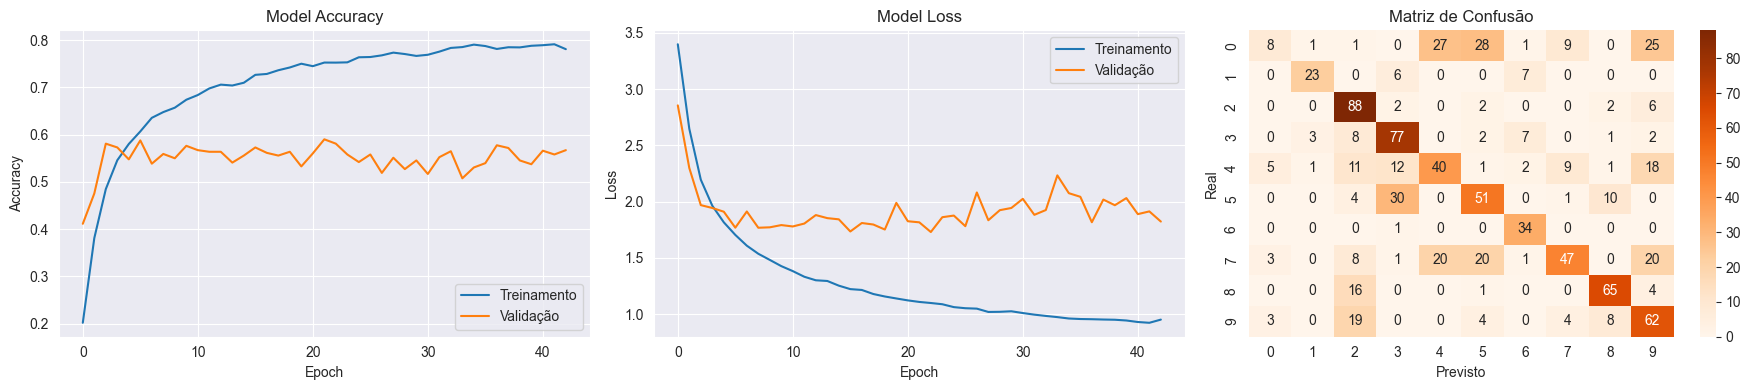

Fold 2
28/28 [==============================] - 0s 3ms/step


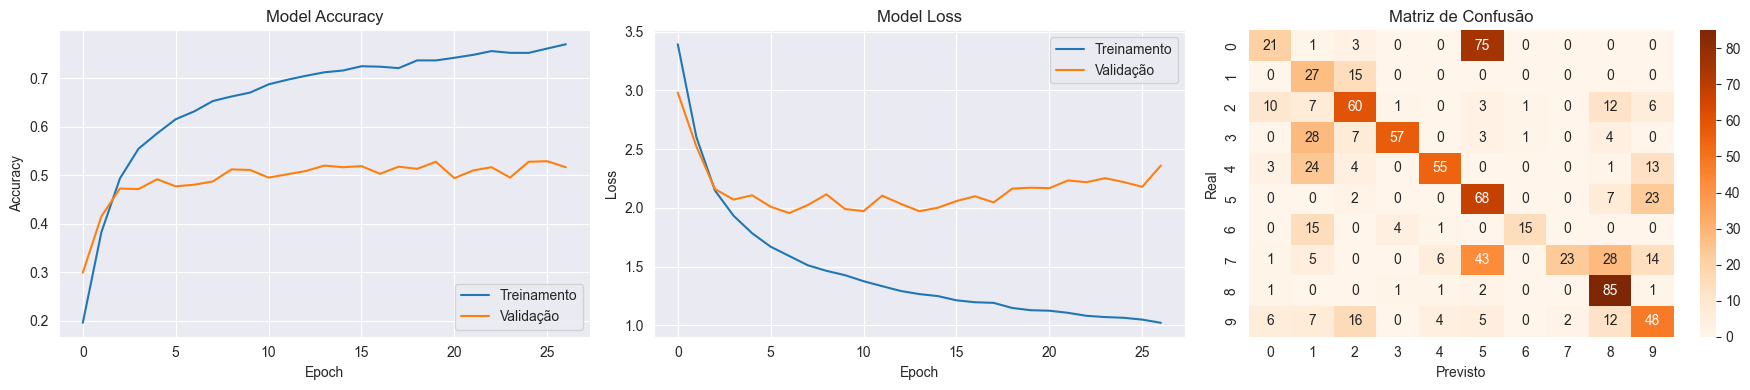

Fold 3
29/29 [==============================] - 0s 3ms/step


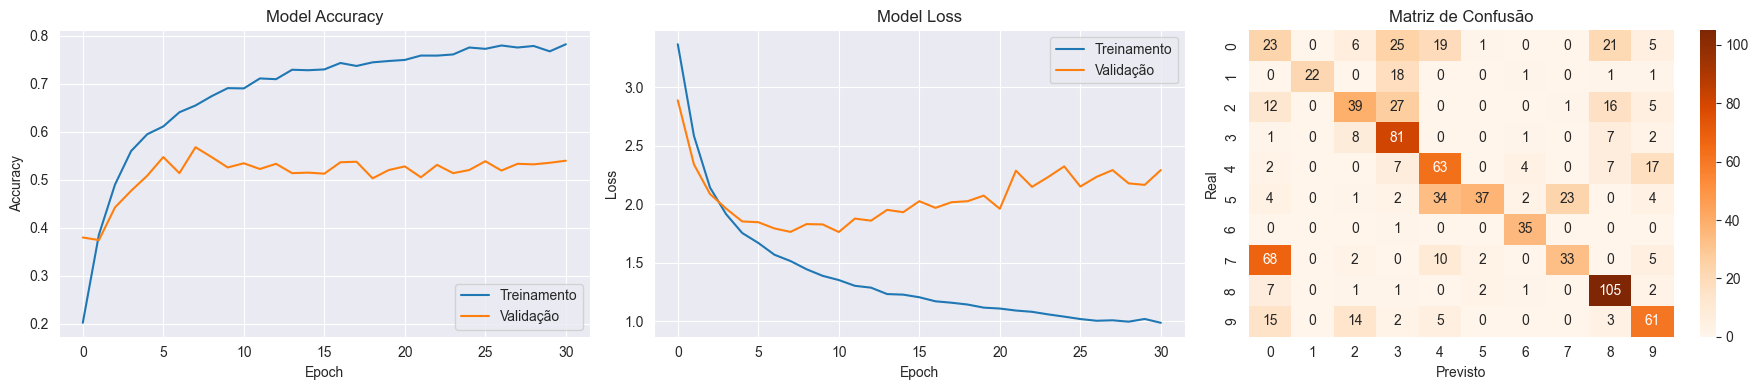

Fold 4
31/31 [==============================] - 0s 4ms/step


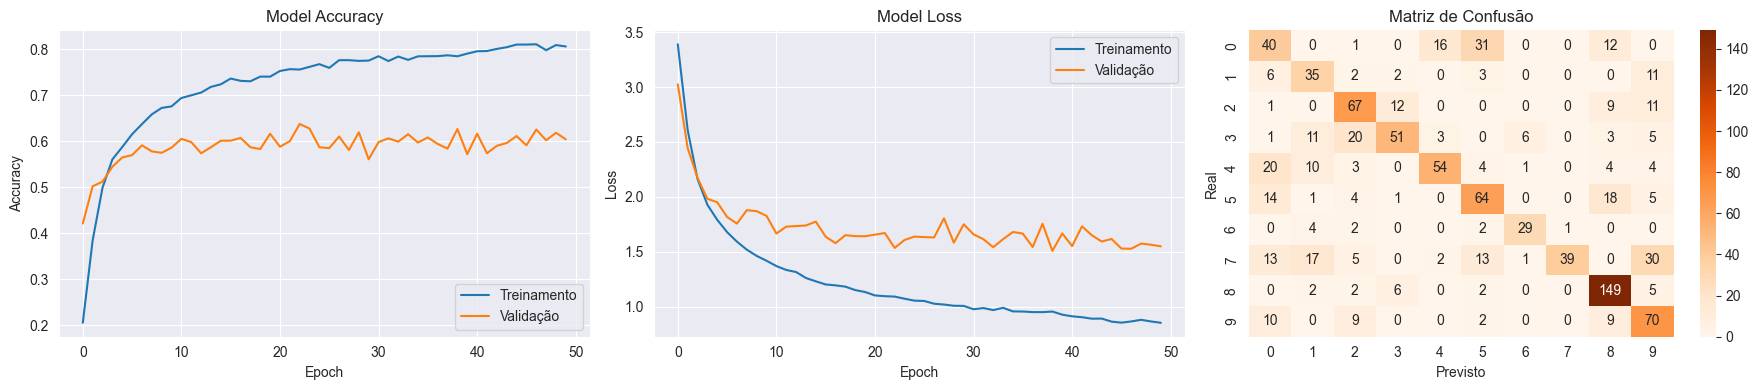

Fold 5
30/30 [==============================] - 0s 4ms/step


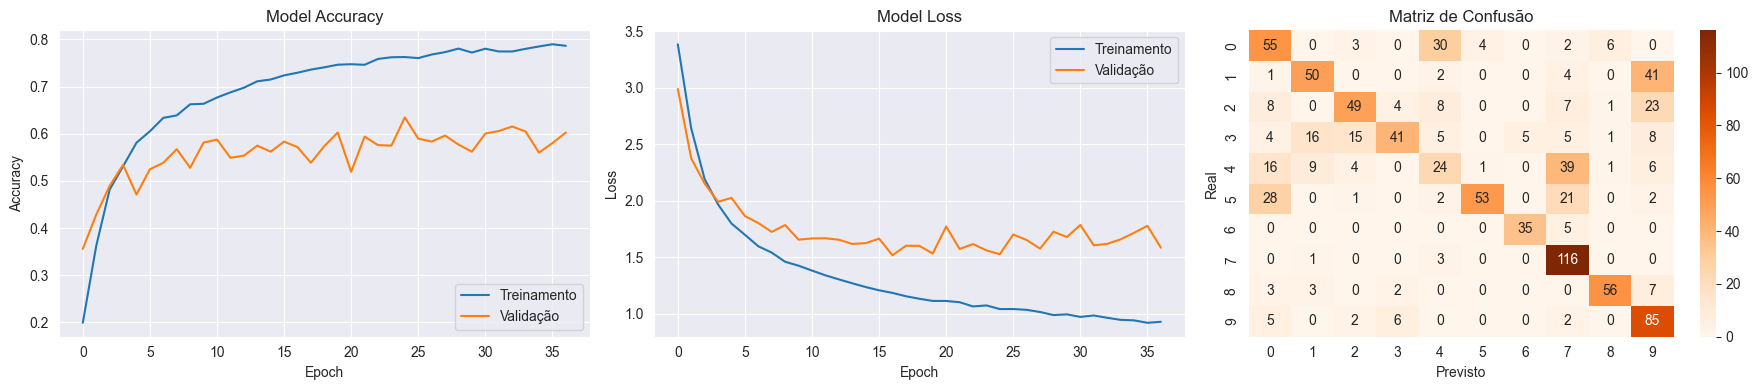

Fold 6
26/26 [==============================] - 0s 5ms/step


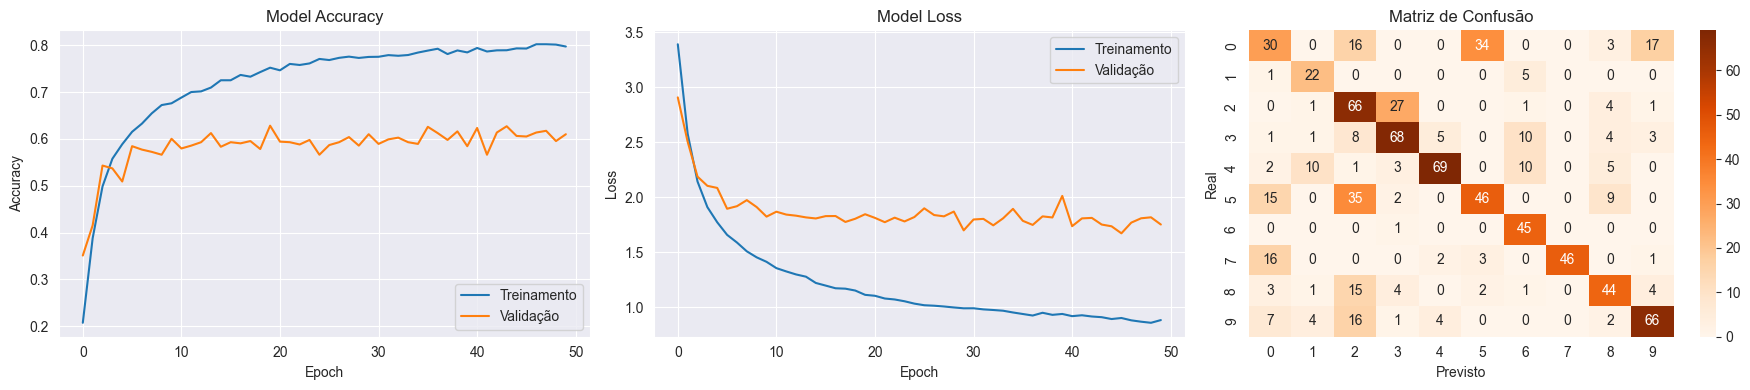

Fold 7
27/27 [==============================] - 0s 6ms/step


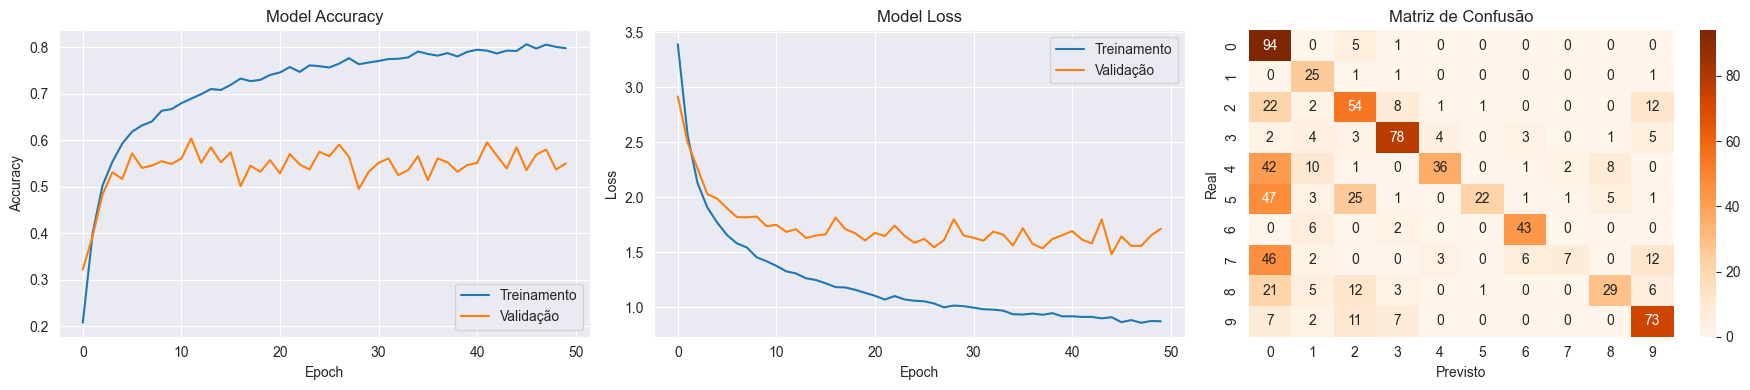

Fold 8
26/26 [==============================] - 0s 5ms/step


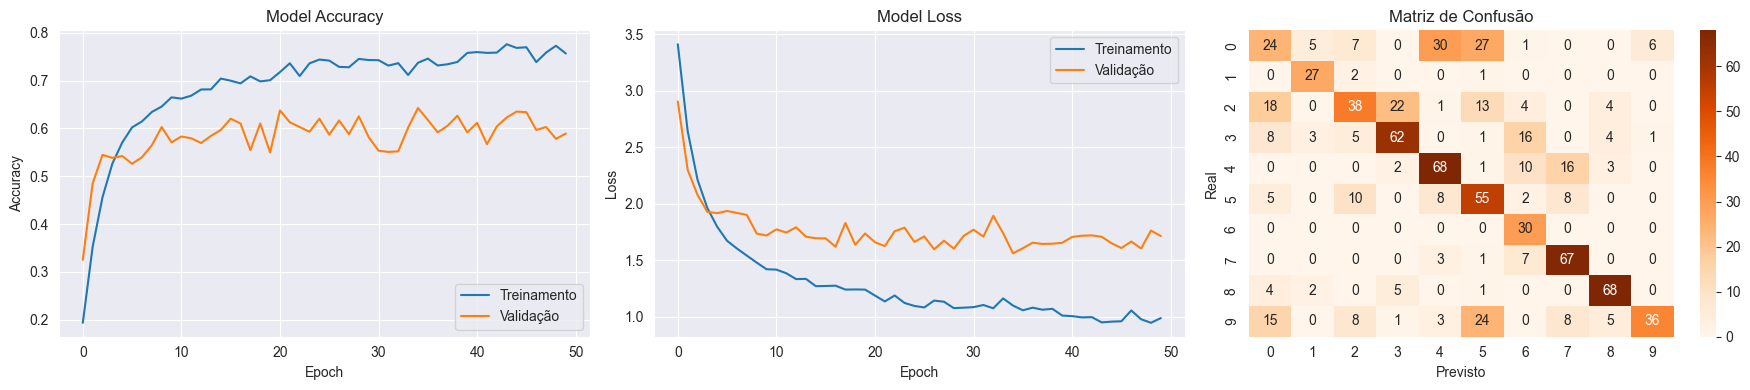

Fold 9
26/26 [==============================] - 0s 3ms/step


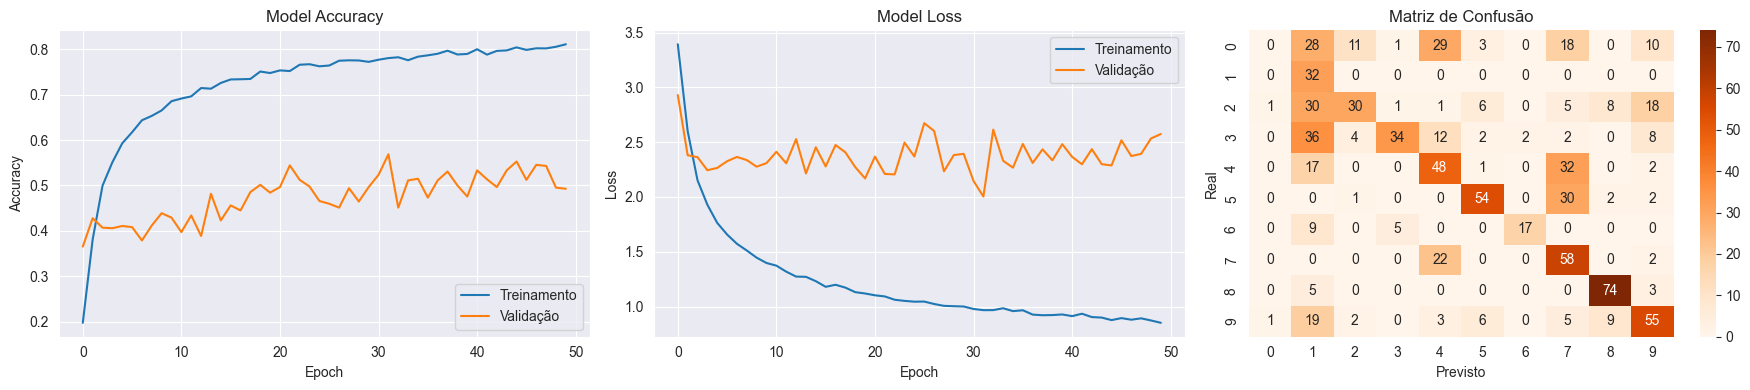

Fold 10
27/27 [==============================] - 0s 3ms/step


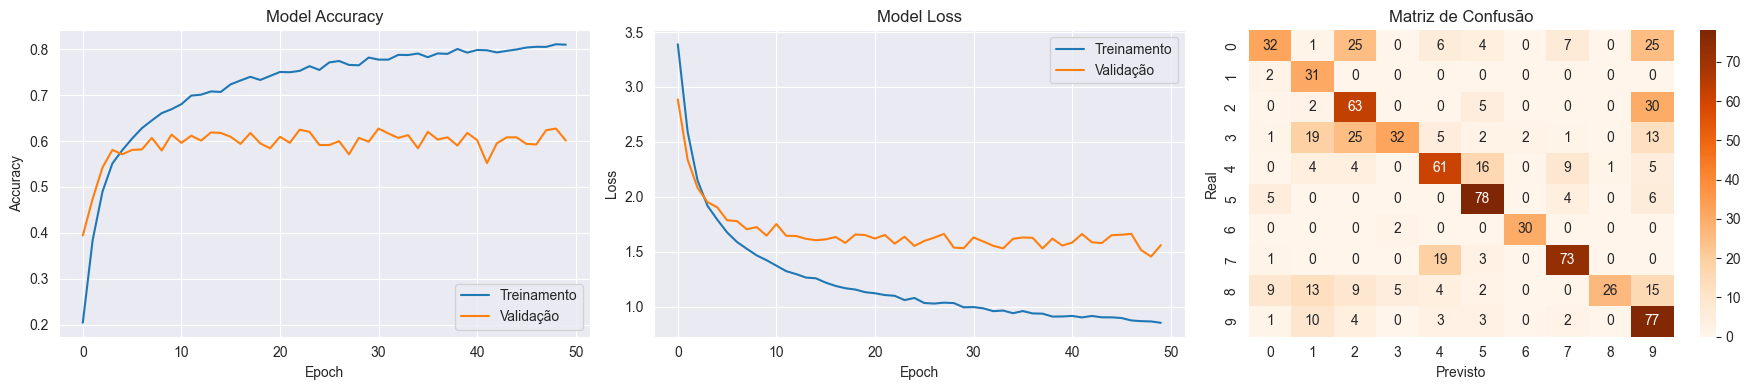


Acurácia Média para o MLP: 0.5673
Desvio Padrão da Acurácia do MLP: 0.0390


In [72]:
resultados_cv_mlp = []  # Lista para armazenar as accuracies em cada fold

# Loop pelos 10 folds de validação cruzada
for fold in range(10):
    print(f"Fold {fold + 1}")

    # Preparar os dados para treino e teste
    dados_treino, rotulos_treino, dados_teste, rotulos_teste = preparar_dados(fold)

    # Construir o modelo MLP com os parâmetros definidos
    modelo_mlp = criar_MLP(
        input_neurons=512,
        hidden_neurons=512,
        output_neurons=10,
        learning_rate=0.0005,
        regulizer=0.001,
        dropout=0.5
    )

    # Treinar o modelo com os dados
    historico = treinar_MLP(
        modelo_mlp, 
        dados_treino, 
        rotulos_treino, 
        dados_teste, 
        rotulos_teste,
        patience=20,
        batch_size=128,
        num_epochs=50
    )

    # Fazer previsões no conjunto de teste
    previsoes = modelo_mlp.predict(dados_teste)
    rotulos_previstos = np.argmax(previsoes, axis=1)

    # Visualizar gráficos de desempenho
    visualizar_resultados(
        historico, 
        rotulos_teste, 
        rotulos_previstos, 
        nomes_classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    )

    # Calcular a accuracy e armazenar
    acuracia = accuracy_score(rotulos_teste, rotulos_previstos)
    resultados_cv_mlp.append(acuracia)

# Calcular métricas gerais
media_acuracia_mlp = np.mean(resultados_cv_mlp)
desvio_padrao_mlp = np.std(resultados_cv_mlp)

# Exibir os resultados
print(f"\nAcurácia Média para o MLP: {media_acuracia_mlp:.4f}")
print(f"Desvio Padrão da Acurácia do MLP: {desvio_padrao_mlp:.4f}")

## CNN
#### Avaliação de desempenho da CNN e parâmetros definidos do modelo

Fold 1
28/28 [==============================] - 0s 2ms/step


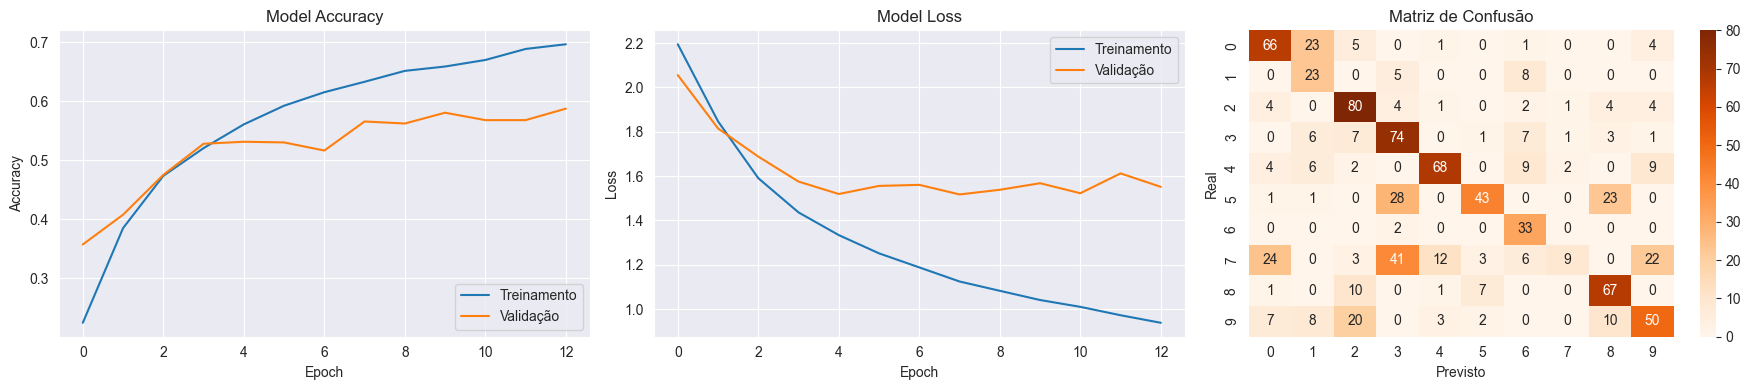

Fold 2
28/28 [==============================] - 0s 3ms/step


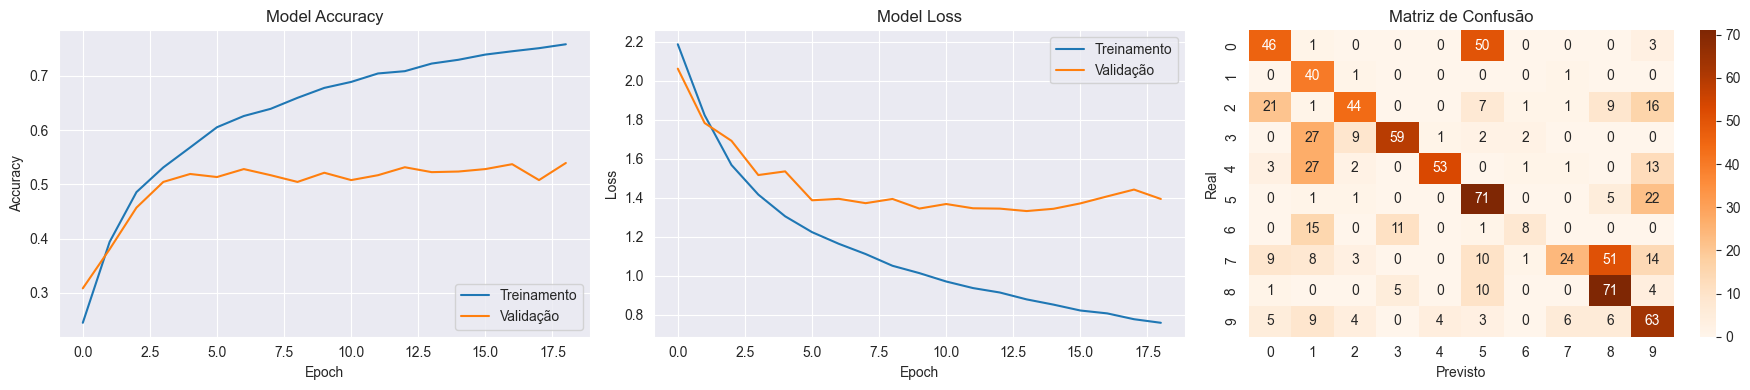

Fold 3
29/29 [==============================] - 0s 3ms/step


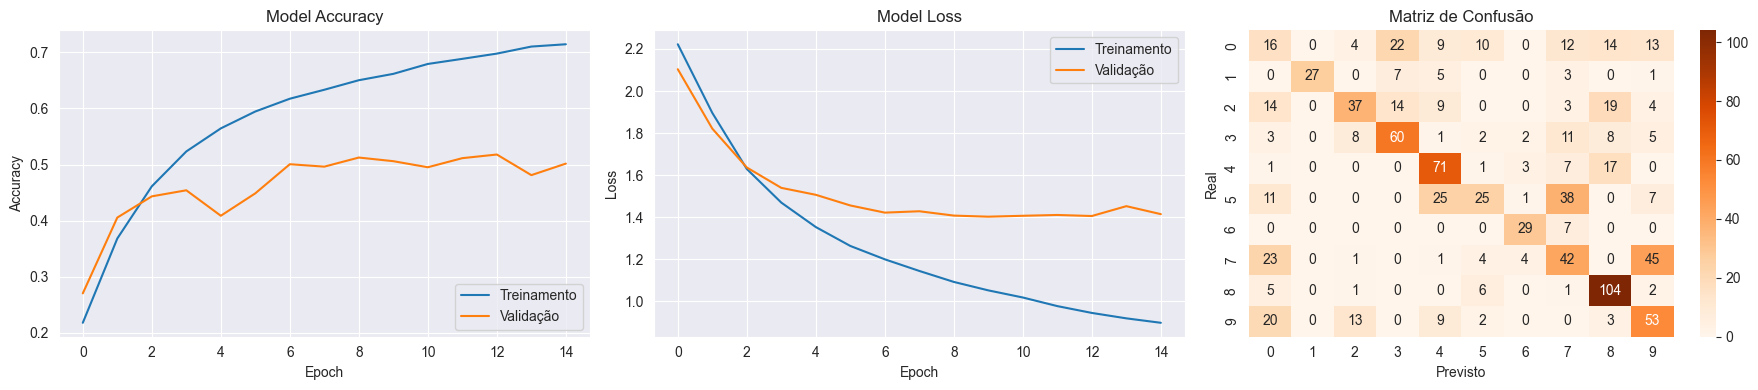

Fold 4
31/31 [==============================] - 0s 2ms/step


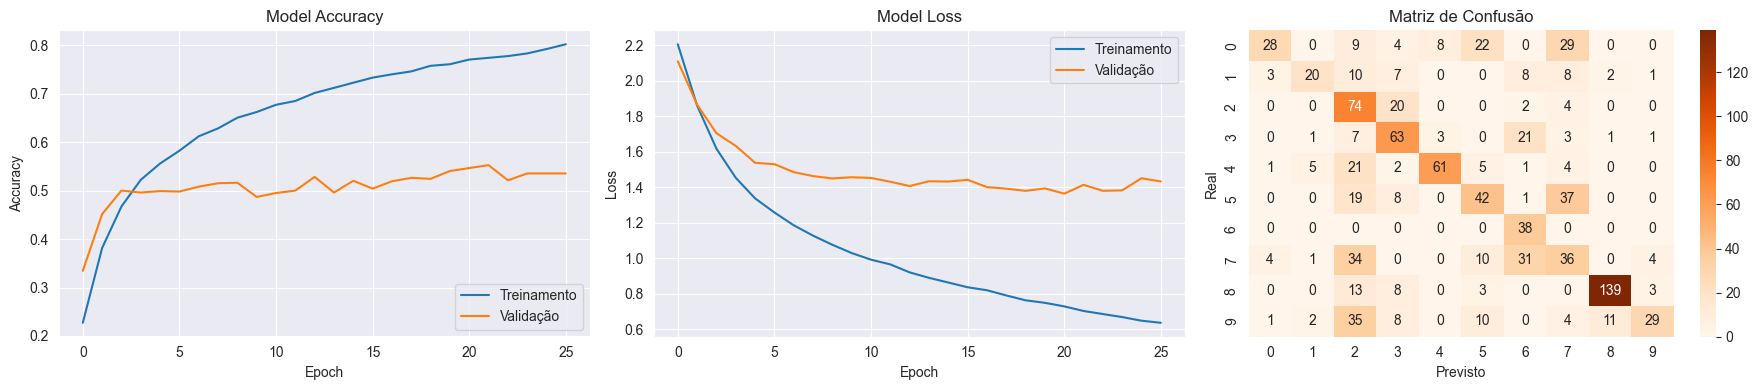

Fold 5
30/30 [==============================] - 0s 2ms/step


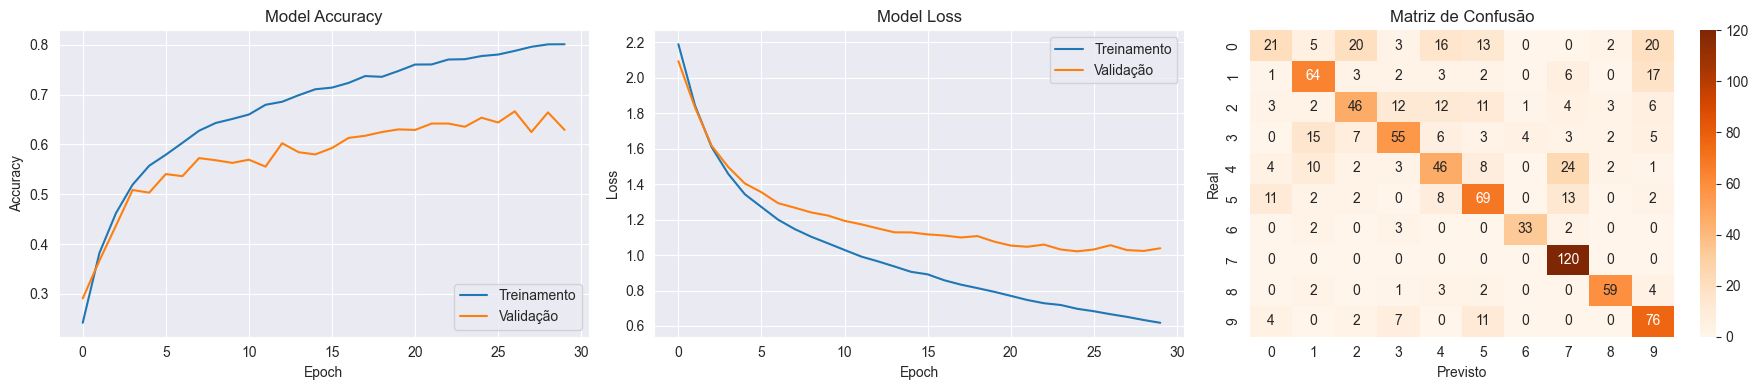

Fold 6
26/26 [==============================] - 0s 3ms/step


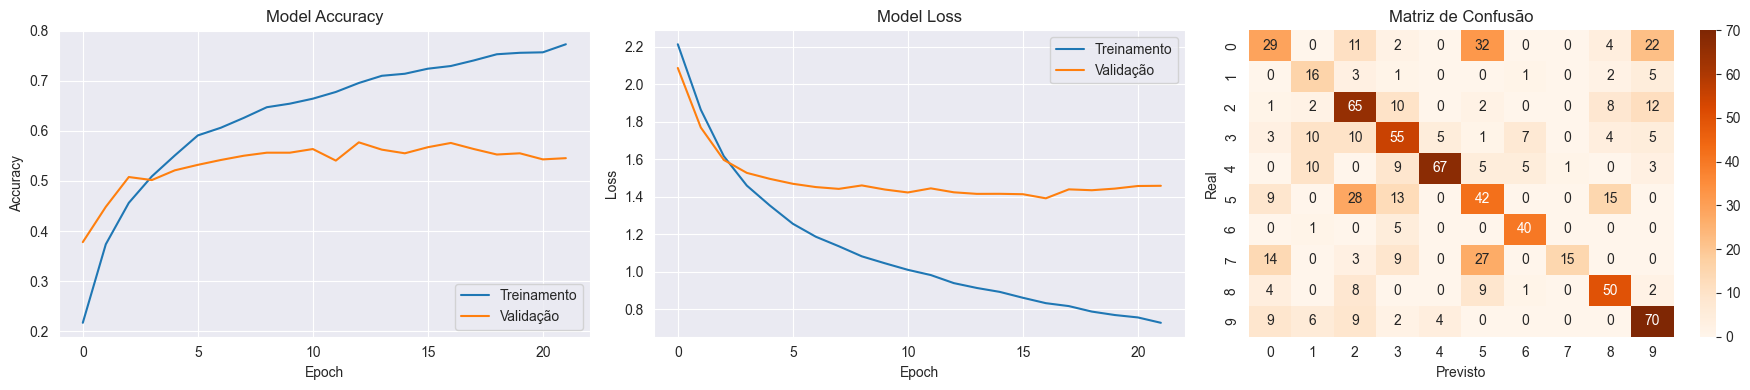

Fold 7
27/27 [==============================] - 0s 3ms/step


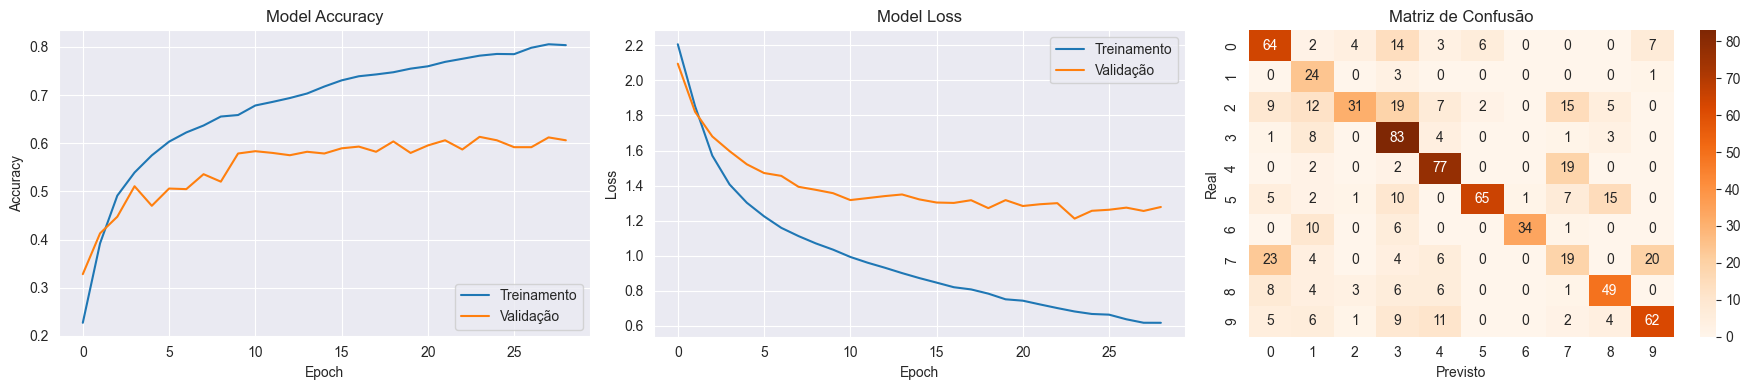

Fold 8
26/26 [==============================] - 0s 3ms/step


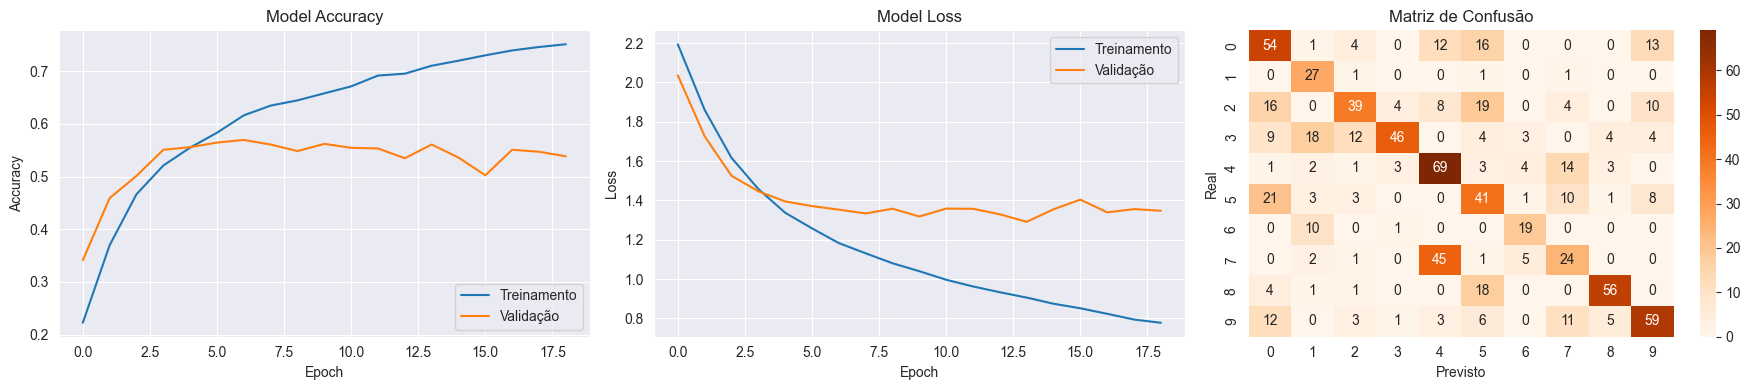

Fold 9
26/26 [==============================] - 0s 3ms/step


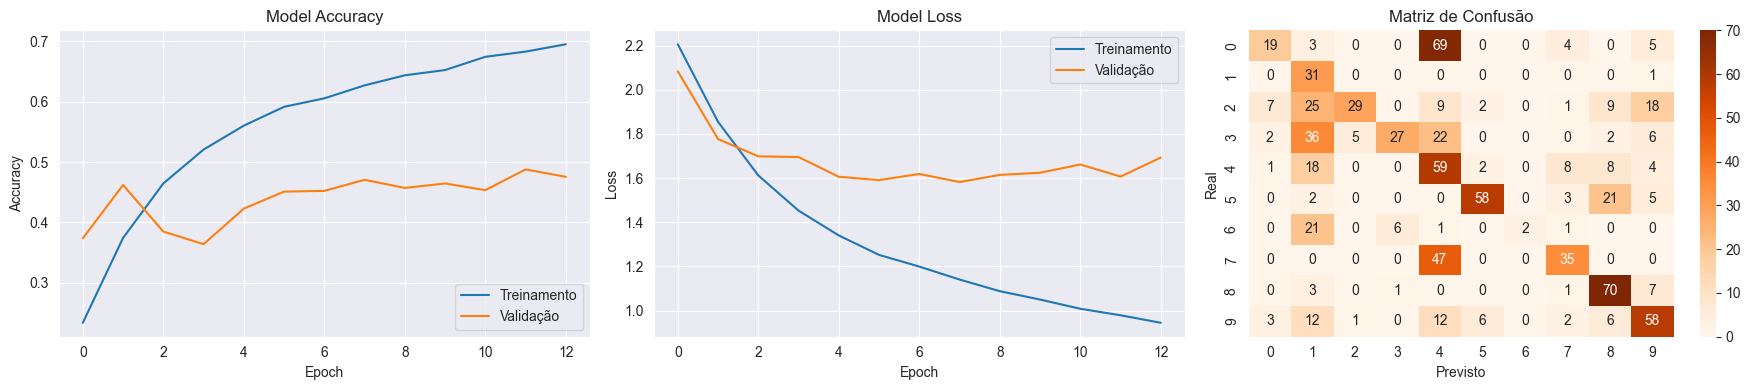

Fold 10
27/27 [==============================] - 0s 3ms/step


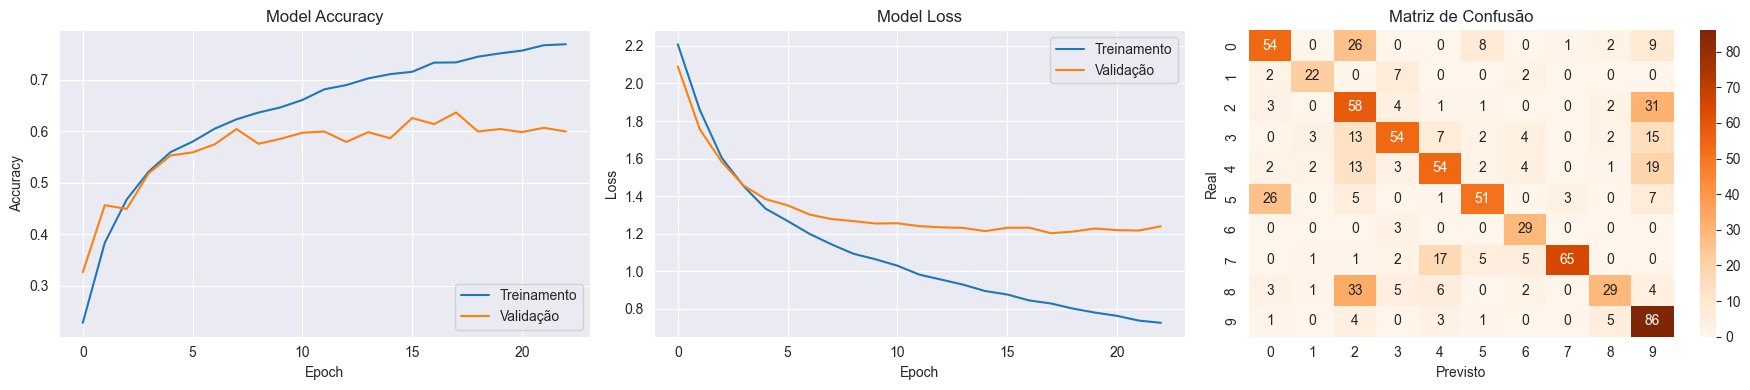


Acurácia Média para a CNN: 0.5559
Desvio Padrão da Acurácia da CNN: 0.0462


In [71]:
resultados_cv_cnn = []  # Lista para armazenar as accuracies em cada fold

# Loop pelos 10 folds de validação cruzada
for fold in range(10):
    print(f"Fold {fold + 1}")

    # Preparar os dados para treino e teste
    dados_treino, rotulos_treino, dados_teste, rotulos_teste = preparar_dados(fold)

    # Construir o modelo CNN com os parâmetros definidos
    modelo_cnn = criar_CNN(
        input_shape=dados_treino.shape[1:],
        num_classes=10,
        learning_rate=0.0001,
        dropout_rate=0.5
    )

    # Treinar o modelo com os dados
    historico_cnn = treinar_CNN(
        modelo_cnn,
        dados_treino,
        rotulos_treino,
        dados_teste,
        rotulos_teste,
        patience=5,
        batch_size=32,
        num_epochs=50
    )

    # Fazer previsões no conjunto de teste
    previsoes_cnn = modelo_cnn.predict(dados_teste)
    rotulos_previstos_cnn = np.argmax(previsoes_cnn, axis=1)

    # Visualizar gráficos de desempenho
    visualizar_resultados(
        historico_cnn,
        rotulos_teste,
        rotulos_previstos_cnn,
        nomes_classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    )

    # Calcular a accuracy e armazenar o resultado
    acuracia_cnn = accuracy_score(rotulos_teste, rotulos_previstos_cnn)
    resultados_cv_cnn.append(acuracia_cnn)

# Calcular métricas gerais
media_acuracia_cnn = np.mean(resultados_cv_cnn)
desvio_padrao_cnn = np.std(resultados_cv_cnn)

# Exibir os resultados
print(f"\nAcurácia Média para a CNN: {media_acuracia_cnn:.4f}")
print(f"Desvio Padrão da Acurácia da CNN: {desvio_padrao_cnn:.4f}")